# Project 1: Image Classification

## Task 0: Getting Started

Read the getting started guide titled **"Python for Deep Learning"** and get familiar with Python and PyTorch. Read the provided code below and get familiar with the commands and their parameters to understand what the code is trying to do. We recommend to spend a fair amount of time to understand all the different parts of the code. This understanding will be important for this and future projects.

The goal of this project is to implement the *“Hello World!”* program of deep learning: designing and training a network that performs image classification. The dataset we will be using is CIFAR10 which is a large set of images that are classified into 10 classes (airplane, bird, cat, etc.).

## Task 1:  Data Loading (10 points)
Complete the **DataLoader** below which we will use to load images of the cifar10 dataset provided by torchvision. Your task is to normalize it by shifting and scaling it by a factor of 0.5. For the training set, introduce random transformations (e.g. flips) for data augmentation.

In [1]:
from __future__ import print_function, division

import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import Image
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for testing
data_transforms = {
    'train': transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                 transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                ]),
    'test': transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                               ])
}

# Load CIFAR10
image_datasets = {x: torchvision.datasets.CIFAR10(root='./data', train=(x=='train'), download=True, transform=data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=(x=='train'), num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# Move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Training on GPU.")
else:
    print("Training on CPU.")

Files already downloaded and verified
Files already downloaded and verified
Training on GPU.


### Visualize a few images

Let’s visualize a few training images so as to understand the data augmentations. The results should look like:

<img src="https://i.imgur.com/Sa6l1go.png" width="400" align="left">

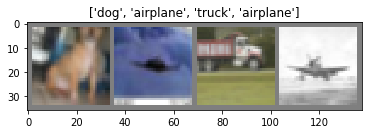

In [2]:
# TODO Task 1:  Run this cell and try to understand the output of each step

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Task 2: Basic Networks (20 points)
1. Create a Fully connected Network (FcNet) as follows in the Jupyter Notebook:
```
FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the FcNet for **3** epoches and record the training time and accuracy in your final report.

2. Create a Convolutional Network (ConvNet) as follows in the Jupyter Notebook:
```
ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```
Train the ConvNet for **3** epoches and record the training time and accuracy in your final report. 

*Use the default SGD optimizer ( lr=0.001, momentum=0.9) for training.

### Model training code (do not modify except for plotting the loss curve)

In [3]:
def train_model(model, criterion, optimizer, num_epochs=25, save_path='saved_weight.pth'):
    since = time.time()
    losses = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train': model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            losses.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    torch.save(model.state_dict(), save_path)
    return losses

### 1) FC Network

In [21]:
# 1) Define a Fully Connected Neural Network
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        self.fc1 = nn.Linear(3072, 1024)
        self.fc2 = nn.Linear(1024, 400)
        self.fc3 = nn.Linear(400, 84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

model_ft = FcNet()
model_ft = model_ft.to(device)
print(model_ft)

FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)


In [22]:
criterion_fcnet = nn.CrossEntropyLoss()
optimizer_fcnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [23]:
train_model(model_ft, criterion_fcnet, optimizer_fcnet, num_epochs=3, save_path='fcnet.pth')

Epoch 0/2
----------
train Loss: 1.7268 Acc: 0.3812
Epoch 1/2
----------
train Loss: 1.4999 Acc: 0.4654
Epoch 2/2
----------
train Loss: 1.4143 Acc: 0.4955

Training complete in 1m 51s


FcNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

### 2) CNN

In [24]:
# 2) Define a Convolutional Neural Network
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [25]:
criterion_cvnet = nn.CrossEntropyLoss()
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [26]:
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet.pth')

Epoch 0/2
----------
train Loss: 1.7479 Acc: 0.3561
Epoch 1/2
----------
train Loss: 1.4229 Acc: 0.4872
Epoch 2/2
----------
train Loss: 1.3180 Acc: 0.5303

Training complete in 2m 14s


ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Task 3: Design Your Network I (20 points)
Define your own Convolutional Network (MyNet) starting from the configuration in Task 2.2. Add following modifications and train the Network for **25** epoches. Keep the best settings for each step (for each step, record the training accuracy of the last epoch and test accuracy in your report):

1. Increase the number of layers: Modify the number of convolutional layers in the network.
2. Increase the number of filters: Modify the number of filters in each convolutional layer of the network. 
3. Modify the filter sizes in each convolutional layer. Experiment with different filter sizes (3x3, 5x5 and 7x7).

In [32]:
class ConvNet0_0(nn.Module):
    def __init__(self):
        super(ConvNet0_0, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, padding=2, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, padding=2, kernel_size=5)
        self.fc1 = nn.Linear(1024, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet0_0()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet0_0(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [33]:
criterion_cvnet = nn.CrossEntropyLoss()
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [34]:
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_padded.pth')

Epoch 0/2
----------
train Loss: 1.7001 Acc: 0.3807
Epoch 1/2
----------
train Loss: 1.3229 Acc: 0.5277
Epoch 2/2
----------
train Loss: 1.1956 Acc: 0.5771

Training complete in 2m 14s


ConvNet0_0(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1024, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Since ConvNet with padded layers has got even higher accuracy after training, we will base alterations of the network on ConvNet0_0().

In [39]:
class ConvNet1_1(nn.Module):
    def __init__(self):
        super(ConvNet1_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, padding=2, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, padding=2, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 26, padding=2, kernel_size=5)
        self.fc1 = nn.Linear(416, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet1_1()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet1_1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 26, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=416, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [40]:
criterion_cvnet = nn.CrossEntropyLoss()
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_1_1.pth')

Epoch 0/2
----------
train Loss: 1.8442 Acc: 0.3140
Epoch 1/2
----------
train Loss: 1.3952 Acc: 0.4950
Epoch 2/2
----------
train Loss: 1.2281 Acc: 0.5642

Training complete in 2m 32s


ConvNet1_1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(16, 26, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=416, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [42]:
class ConvNet1_2(nn.Module):
    def __init__(self):
        super(ConvNet1_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, padding=1, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(6, 16, padding=1, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 32, padding=1, kernel_size=3)
        self.fc1 = nn.Linear(512, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet1_2()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet1_2(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [43]:
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_1_2.pth')

Epoch 0/2
----------
train Loss: 1.8533 Acc: 0.3167
Epoch 1/2
----------
train Loss: 1.4048 Acc: 0.4936
Epoch 2/2
----------
train Loss: 1.2303 Acc: 0.5627

Training complete in 2m 34s


ConvNet1_2(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [47]:
class ConvNet2_1(nn.Module):
    def __init__(self):
        super(ConvNet2_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, padding=2, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, padding=2, kernel_size=5)
        self.fc1 = nn.Linear(2048, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet2_1()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet2_1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [48]:
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_2_1.pth')

Epoch 0/2
----------
train Loss: 1.6184 Acc: 0.4102
Epoch 1/2
----------
train Loss: 1.2159 Acc: 0.5663
Epoch 2/2
----------
train Loss: 1.0638 Acc: 0.6226

Training complete in 2m 17s


ConvNet2_1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
class ConvNet2_2(nn.Module):
    def __init__(self):
        super(ConvNet2_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, padding=2, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, padding=2, kernel_size=5)
        self.fc1 = nn.Linear(4096, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet2_2()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet2_2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [50]:
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_2_2.pth')

Epoch 0/2
----------
train Loss: 1.5874 Acc: 0.4181
Epoch 1/2
----------
train Loss: 1.1649 Acc: 0.5882
Epoch 2/2
----------
train Loss: 0.9984 Acc: 0.6495

Training complete in 2m 12s


ConvNet2_2(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=4096, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [52]:
class ConvNet2_3(nn.Module):
    def __init__(self):
        super(ConvNet2_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=2, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, padding=2, kernel_size=5)
        self.fc1 = nn.Linear(8192, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet2_3()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet2_3(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [53]:
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_2_3.pth')

Epoch 0/2
----------
train Loss: 1.5377 Acc: 0.4400
Epoch 1/2
----------
train Loss: 1.0997 Acc: 0.6135
Epoch 2/2
----------
train Loss: 0.9292 Acc: 0.6756

Training complete in 2m 14s


ConvNet2_3(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [54]:
class ConvNet3_1(nn.Module):
    def __init__(self):
        super(ConvNet3_1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=1, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, padding=1, kernel_size=3)
        self.fc1 = nn.Linear(8192, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet3_1()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet3_1(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [55]:
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_3_1.pth')

Epoch 0/2
----------
train Loss: 1.5405 Acc: 0.4398
Epoch 1/2
----------
train Loss: 1.1127 Acc: 0.6053
Epoch 2/2
----------
train Loss: 0.9545 Acc: 0.6648

Training complete in 2m 16s


ConvNet3_1(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [56]:
class ConvNet3_2(nn.Module):
    def __init__(self):
        super(ConvNet3_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=3, kernel_size=7)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, padding=3, kernel_size=7)
        self.fc1 = nn.Linear(8192, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ft = ConvNet3_2()
model_ft = model_ft.to(device)
print(model_ft)

ConvNet3_2(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [57]:
optimizer_cvnet = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
train_model(model_ft, criterion_cvnet, optimizer_cvnet, num_epochs=3, save_path='cvnet_3_2.pth')

Epoch 0/2
----------
train Loss: 1.5362 Acc: 0.4413
Epoch 1/2
----------
train Loss: 1.1253 Acc: 0.6040
Epoch 2/2
----------
train Loss: 0.9412 Acc: 0.6727

Training complete in 2m 15s


ConvNet3_2(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Task 4: Design Your Network II (20 points)
Keeping the best settings of Task 3, use **Dropout** in fully connected layers and Batch Normalization (choose a suitable batch size) in convolutional layers. Record the training accuracy of the last epoch and test accuracy in your report.

### Design Your Network

In [4]:
# Define a Convolutional Neural Network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, padding=2, kernel_size=5, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(64, 128, padding=2, kernel_size=5, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.fc1 = nn.Linear(8192, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        batch_size = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = x.view(batch_size, -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [29]:
model_ft = MyNet()
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# TODO Task 5: Optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [67]:
## Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6446 Acc: 0.4022
Epoch 1/24
----------
train Loss: 1.3503 Acc: 0.5240
Epoch 2/24
----------
train Loss: 1.2145 Acc: 0.5791
Epoch 3/24
----------
train Loss: 1.1161 Acc: 0.6139
Epoch 4/24
----------
train Loss: 1.0387 Acc: 0.6440
Epoch 5/24
----------
train Loss: 0.9798 Acc: 0.6650
Epoch 6/24
----------
train Loss: 0.9352 Acc: 0.6803
Epoch 7/24
----------
train Loss: 0.8934 Acc: 0.6982
Epoch 8/24
----------
train Loss: 0.8703 Acc: 0.7035
Epoch 9/24
----------
train Loss: 0.8318 Acc: 0.7164
Epoch 10/24
----------
train Loss: 0.8088 Acc: 0.7241
Epoch 11/24
----------
train Loss: 0.7921 Acc: 0.7323
Epoch 12/24
----------
train Loss: 0.7672 Acc: 0.7371
Epoch 13/24
----------
train Loss: 0.7488 Acc: 0.7453
Epoch 14/24
----------
train Loss: 0.7342 Acc: 0.7520
Epoch 15/24
----------
train Loss: 0.7206 Acc: 0.7556
Epoch 16/24
----------
train Loss: 0.6990 Acc: 0.7626
Epoch 17/24
----------
train Loss: 0.6923 Acc: 0.7643
Epoch 18/24
----------
train Loss: 0.6

## Task 5: The Optimizer (20 points)
Keeping the best settings of Task 4, use 3 different optimizers (SGD, ADAM and RMSProp) with 3 different learning rates (0.001, 0.01, 0.1) . Plot the loss curves (Training loss vs Training step) for each case.

return value of function "train_model" has been changed at this point

In [6]:
optimizer = optim.SGD(model_ft.parameters(), lr=0.001)
losses_001_SGD = train_model(model_ft, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6689 Acc: 0.3900
Epoch 1/9
----------
train Loss: 1.3259 Acc: 0.5258
Epoch 2/9
----------
train Loss: 1.1946 Acc: 0.5773
Epoch 3/9
----------
train Loss: 1.1192 Acc: 0.6046
Epoch 4/9
----------
train Loss: 1.0582 Acc: 0.6307
Epoch 5/9
----------
train Loss: 1.0151 Acc: 0.6442
Epoch 6/9
----------
train Loss: 0.9723 Acc: 0.6612
Epoch 7/9
----------
train Loss: 0.9377 Acc: 0.6728
Epoch 8/9
----------
train Loss: 0.9119 Acc: 0.6840
Epoch 9/9
----------
train Loss: 0.8855 Acc: 0.6934

Training complete in 7m 50s


In [16]:
optimizer = optim.SGD(model_ft.parameters(), lr=0.01)
losses_01_SGD = train_model(model_ft, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.6239 Acc: 0.4123
Epoch 1/9
----------
train Loss: 1.3330 Acc: 0.5313
Epoch 2/9
----------
train Loss: 1.1936 Acc: 0.5851
Epoch 3/9
----------
train Loss: 1.0947 Acc: 0.6234
Epoch 4/9
----------
train Loss: 1.0147 Acc: 0.6506
Epoch 5/9
----------
train Loss: 0.9523 Acc: 0.6740
Epoch 6/9
----------
train Loss: 0.9086 Acc: 0.6889
Epoch 7/9
----------
train Loss: 0.8825 Acc: 0.6988
Epoch 8/9
----------
train Loss: 0.8435 Acc: 0.7112
Epoch 9/9
----------
train Loss: 0.8204 Acc: 0.7214

Training complete in 7m 45s


In [12]:
optimizer = optim.SGD(model_ft.parameters(), lr=0.1)
losses_1_SGD = train_model(model_ft, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
train Loss: 2.3081 Acc: 0.1011
Epoch 1/9
----------
train Loss: 2.3090 Acc: 0.0974
Epoch 2/9
----------
train Loss: 2.3081 Acc: 0.1009
Epoch 3/9
----------
train Loss: 2.3085 Acc: 0.0984
Epoch 4/9
----------
train Loss: 2.3081 Acc: 0.1000
Epoch 5/9
----------
train Loss: 2.3084 Acc: 0.0994
Epoch 6/9
----------
train Loss: 2.3086 Acc: 0.0980
Epoch 7/9
----------
train Loss: 2.3083 Acc: 0.0978
Epoch 8/9
----------
train Loss: 2.3086 Acc: 0.0999
Epoch 9/9
----------
train Loss: 2.3085 Acc: 0.1007

Training complete in 7m 54s


In [37]:
losses_001_SGD

[1.6688675293254853,
 1.3258605150318146,
 1.1946222650027276,
 1.1191962688326835,
 1.0581714764451982,
 1.015088370306492,
 0.9723418320655822,
 0.9376602974939346,
 0.9119118077683449,
 0.8854776505565644]

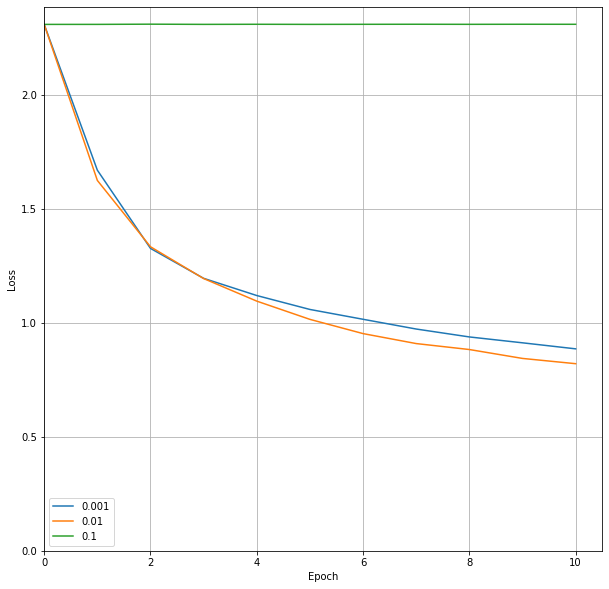

In [41]:
plt.figure(figsize=(10, 10))
plt.plot(np.arange(11), [2.308] + losses_001_SGD, label="0.001")
plt.plot(np.arange(11), [2.308] + losses_01_SGD, label="0.01")
plt.plot(np.arange(11), [2.308] + losses_1_SGD, label="0.1")
plt.xlim(0, )
plt.ylim(0, )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("SGD.png")
plt.show()

In [43]:
lrs = [0.001, 0.01, 0.1]
losses_adam = []
for lr in lrs:
    model_ft = MyNet()
    model_ft = model_ft.to(device)
    optimizer = optim.Adam(model_ft.parameters(), lr=lr)
    loss = train_model(model_ft, criterion, optimizer, num_epochs=10)
    losses_adam.append(loss)

Epoch 0/9
----------
train Loss: 1.8142 Acc: 0.3232
Epoch 1/9
----------
train Loss: 1.5611 Acc: 0.4338
Epoch 2/9
----------
train Loss: 1.4691 Acc: 0.4783
Epoch 3/9
----------
train Loss: 1.4110 Acc: 0.4987
Epoch 4/9
----------
train Loss: 1.3612 Acc: 0.5181
Epoch 5/9
----------
train Loss: 1.3161 Acc: 0.5339
Epoch 6/9
----------
train Loss: 1.2765 Acc: 0.5454
Epoch 7/9
----------
train Loss: 1.2584 Acc: 0.5556
Epoch 8/9
----------
train Loss: 1.2418 Acc: 0.5597
Epoch 9/9
----------
train Loss: 1.2183 Acc: 0.5691

Training complete in 10m 10s
Epoch 0/9
----------
train Loss: 2.3168 Acc: 0.1029
Epoch 1/9
----------
train Loss: 2.3067 Acc: 0.0984
Epoch 2/9
----------
train Loss: 2.3066 Acc: 0.0996
Epoch 3/9
----------
train Loss: 2.3066 Acc: 0.0983
Epoch 4/9
----------
train Loss: 2.3065 Acc: 0.0987
Epoch 5/9
----------
train Loss: 2.3065 Acc: 0.1001
Epoch 6/9
----------
train Loss: 2.3065 Acc: 0.0997
Epoch 7/9
----------
train Loss: 2.3067 Acc: 0.0991
Epoch 8/9
----------
train Loss: 2

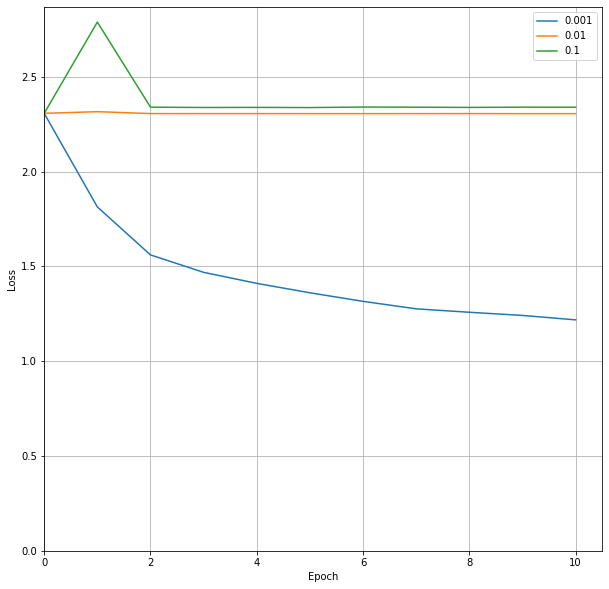

In [45]:
plt.figure(figsize=(10, 10))
counter = 0
for lr in lrs:
    plt.plot(np.arange(11), [2.308] + losses_adam[counter], label=str(lr))
    counter += 1
plt.xlim(0, )
plt.ylim(0, )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("Adam.png")
plt.show()

In [48]:
losses_rmsprop = []
for lr in lrs:
    model_ft = MyNet()
    model_ft = model_ft.to(device)
    optimizer = optim.RMSprop(model_ft.parameters(), lr=lr)
    loss = train_model(model_ft, criterion, optimizer, num_epochs=10)
    losses_rmsprop.append(loss)

Epoch 0/9
----------
train Loss: 1.8042 Acc: 0.3192
Epoch 1/9
----------
train Loss: 1.5399 Acc: 0.4261
Epoch 2/9
----------
train Loss: 1.4291 Acc: 0.4813
Epoch 3/9
----------
train Loss: 1.3375 Acc: 0.5254
Epoch 4/9
----------
train Loss: 1.2558 Acc: 0.5667
Epoch 5/9
----------
train Loss: 1.2152 Acc: 0.5855
Epoch 6/9
----------
train Loss: 1.2053 Acc: 0.5938
Epoch 7/9
----------
train Loss: 1.1853 Acc: 0.6029
Epoch 8/9
----------
train Loss: 1.1645 Acc: 0.6131
Epoch 9/9
----------
train Loss: 1.1557 Acc: 0.6173

Training complete in 9m 13s
Epoch 0/9
----------
train Loss: 2.4889 Acc: 0.0984
Epoch 1/9
----------
train Loss: 2.3065 Acc: 0.0983
Epoch 2/9
----------
train Loss: 2.3063 Acc: 0.0999
Epoch 3/9
----------
train Loss: 2.3064 Acc: 0.1000
Epoch 4/9
----------
train Loss: 2.3065 Acc: 0.0992
Epoch 5/9
----------
train Loss: 2.3062 Acc: 0.0990
Epoch 6/9
----------
train Loss: 2.3063 Acc: 0.1010
Epoch 7/9
----------
train Loss: 2.3064 Acc: 0.1002
Epoch 8/9
----------
train Loss: 2.

In [ ]:
plt.figure(figsize=(10, 10))
counter = 0
for lr in lrs:
    plt.plot(np.arange(11), [2.308] + losses_rmsprop[counter], label=str(lr))
    counter += 1
plt.xlim(0, )
plt.ylim(0, )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("Adam.png")
plt.show()

Training final model

In [7]:
model_ft = MyNet()
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01)
loss = train_model(model_ft, criterion, optimizer, num_epochs=25, save_path="final_model.pth")

Epoch 0/24
----------
train Loss: 1.6445 Acc: 0.3992
Epoch 1/24
----------
train Loss: 1.3453 Acc: 0.5264
Epoch 2/24
----------
train Loss: 1.2074 Acc: 0.5808
Epoch 3/24
----------
train Loss: 1.1073 Acc: 0.6180
Epoch 4/24
----------
train Loss: 1.0270 Acc: 0.6472
Epoch 5/24
----------
train Loss: 0.9722 Acc: 0.6674
Epoch 6/24
----------
train Loss: 0.9204 Acc: 0.6846
Epoch 7/24
----------
train Loss: 0.8869 Acc: 0.6968
Epoch 8/24
----------
train Loss: 0.8540 Acc: 0.7085
Epoch 9/24
----------
train Loss: 0.8347 Acc: 0.7172
Epoch 10/24
----------
train Loss: 0.8085 Acc: 0.7247
Epoch 11/24
----------
train Loss: 0.7816 Acc: 0.7337
Epoch 12/24
----------
train Loss: 0.7600 Acc: 0.7402
Epoch 13/24
----------
train Loss: 0.7424 Acc: 0.7484
Epoch 14/24
----------
train Loss: 0.7285 Acc: 0.7520
Epoch 15/24
----------
train Loss: 0.7085 Acc: 0.7584
Epoch 16/24
----------
train Loss: 0.6978 Acc: 0.7634
Epoch 17/24
----------
train Loss: 0.6899 Acc: 0.7661
Epoch 18/24
----------
train Loss: 0.6

### Testing the Accuracy

In [5]:
def test_model(model, load_path='saved_weight.pth'):    
    # load the model weights
    model.load_state_dict(torch.load(load_path))
    
    since = time.time()

    for phase in ['test']:
        if phase == 'test':
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

            # statistics
            running_corrects += torch.sum(preds == labels.data)
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Acc: {:.4f}'.format(phase, epoch_acc))

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return 

In [11]:
test_model(model_ft, "final_model.pth")

test Acc: 0.8066
Testing complete in 0m 4s


### Display model predictions

In [15]:
## Display model predictions
## Generic function to display predictions for a few images

def display_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

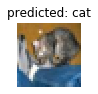

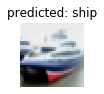

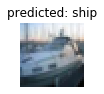

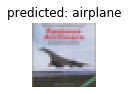

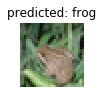

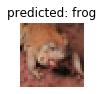

In [16]:
display_predictions(model_ft)

## Task 6: Visualization (10 points)
Visualize feature maps of the first and the last convolutional layer of your final network using **cifar_example.jpg** as input image. Show the visualization in the report.

#### First layer activations
<img src="https://i.imgur.com/kGB9AuP.png" width="400" align="left">

#### Last layer activations

<img src="https://i.imgur.com/qelH05X.png" width="400" align="left">

In [25]:
model_ft = MyNet()
model_ft.load_state_dict(torch.load("final_model.pth"))
model_ft.to(device)

MyNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Save the Feature Maps

In [26]:
# TODO Task 6: Visualization

In [27]:
def transfer_single_img_to_tensor(img_path):
    im = Image.open(img_path)
    img = np.asarray(im)/255
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    
    inp = (img - mean) / std
    inp = np.asarray(inp, dtype=np.float32)
    inp = inp.transpose((2, 0, 1))
    inp = np.expand_dims(inp, axis=0)
    inp = torch.from_numpy(inp, )
    inputs = inp.to(device)
    return inputs

In [28]:
inputs = transfer_single_img_to_tensor('example_imgs/cifar_example.jpg')
model_ft.eval()
with torch.no_grad():
    model_ft(inputs)

In [29]:
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
activation = {}

In [30]:
model_ft.conv1.register_forward_hook(get_activation('conv1'))
model_ft.conv2.register_forward_hook(get_activation('conv2'))

In [31]:
with torch.no_grad():
    model_ft(inputs)

In [36]:
model_ft.featuremap1 = activation['conv1']
model_ft.featuremap2 = activation['conv2']

In [37]:
# Model_ft.featuremap1 and model_ft.featuremap2 should be the first and the last feature maps.
# Add model_ft.featuremap1 and model_ft.featuremap2 at suitable places in your network


feature_ouput1 = model_ft.featuremap1.transpose(1,0).cpu()
feature_ouput2 = model_ft.featuremap2.transpose(1,0).cpu()

In [38]:
def feature_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

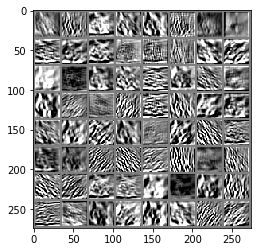

In [39]:
out = torchvision.utils.make_grid(feature_ouput1)
feature_imshow(out)

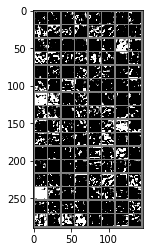

In [40]:
out = torchvision.utils.make_grid(feature_ouput2)
feature_imshow(out)